# Pipeline Bagging

**“Bagging” viene de Bootstrap AGGregatING.**

Usa el remuestreo de bootstrap (muestreo aleatorio con reemplazo) para aprender varios modelos sobre variaciones aleatorias del conjunto de entrenamiento.
En el momento de predicción, las predicciones de cada modelo se agregan para dar las predicciones finales.

In [1]:
# generaremos un conjunto de datos sintético simple para obtener información sobre el arranque (bootstraping).

import pandas as pd
import numpy as np

# cCrea un generador de números aleatorios que se utilizará para establecer la aleatoriedad
rng = np.random.RandomState(1)


def generate_data(n_samples=30):
    """Generate synthetic dataset. Returns `data_train`, `data_test`,
    `target_train`."""
    x_min, x_max = -3, 3
    x = rng.uniform(x_min, x_max, size=n_samples)
    noise = 4.0 * rng.randn(n_samples)
    y = x ** 3 - 0.5 * (x + 1) ** 2 + noise
    y /= y.std()

    data_train = pd.DataFrame(x, columns=["Feature"])
    data_test = pd.DataFrame(
        np.linspace(x_max, x_min, num=300), columns=["Feature"])
    target_train = pd.Series(y, name="Target")

    return data_train, data_test, target_train

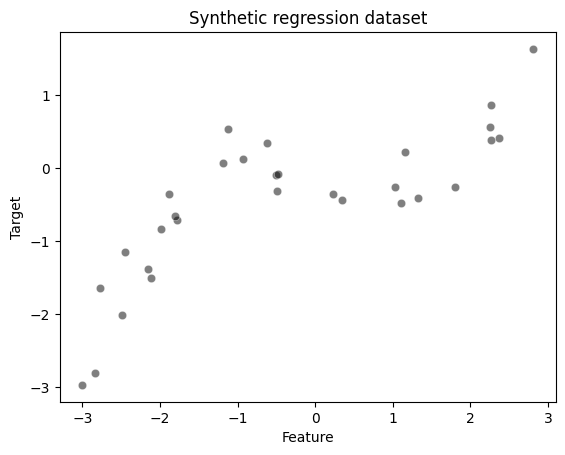

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

data_train, data_test, target_train = generate_data(n_samples=30)
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
_ = plt.title("Synthetic regression dataset")

In [3]:
# La relación entre nuestra característica y el objetivo a predecir no es lineal. 
# Sin embargo, un árbol de decisión es capaz de aproximar dicha dependencia no lineal:

from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3, random_state=0)
tree.fit(data_train, target_train)
y_pred = tree.predict(data_test)

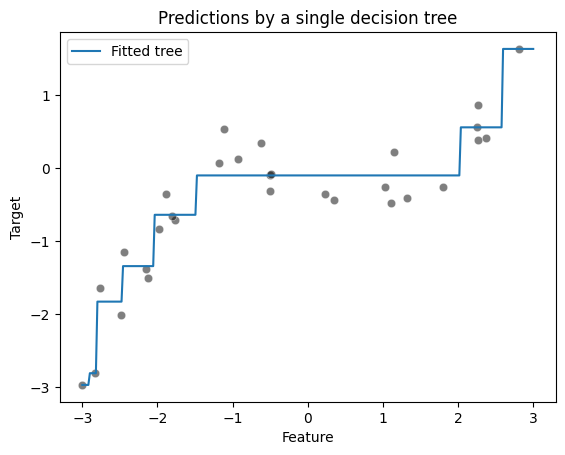

In [4]:
sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
plt.plot(data_test["Feature"], y_pred, label="Fitted tree")
plt.legend()
_ = plt.title("Predictions by a single decision tree")

# Bootstrap resampling

In [5]:
# Crearemos una función que, dados los datos y el target, devolverá una variación remuestreada: data_bootstrap y target_bootstrap.

def bootstrap_sample(data, target):
    # Indices corresponding to a sampling with replacement of the same sample
    # size than the original data
    bootstrap_indices = rng.choice(
        np.arange(target.shape[0]), size=target.shape[0], replace=True,
    )
    # In pandas, we need to use `.iloc` to extract rows using an integer
    # position index:
    data_bootstrap = data.iloc[bootstrap_indices]
    target_bootstrap = target.iloc[bootstrap_indices]
    return data_bootstrap, target_bootstrap

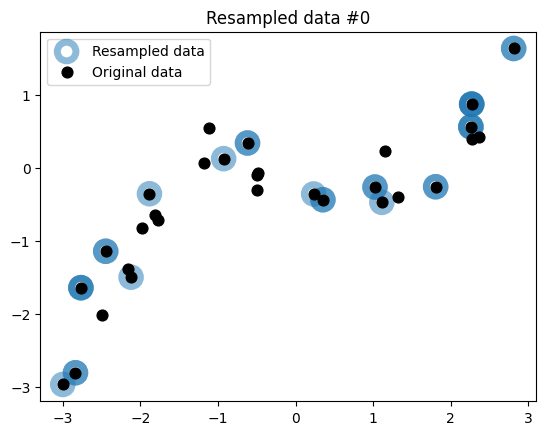

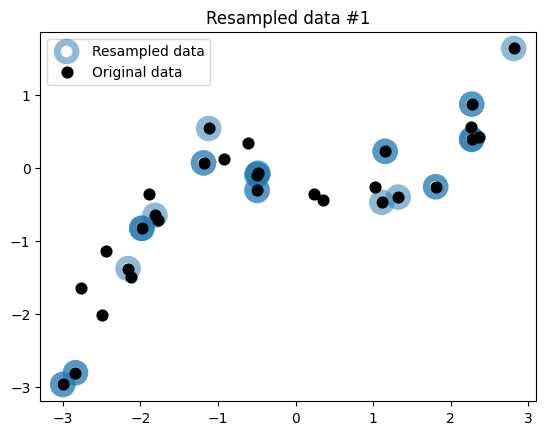

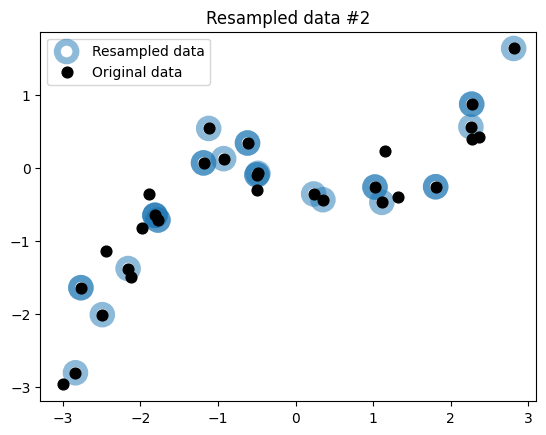

In [7]:
# Generaremos 3 muestras de bootstrap y verificaremos cualitativamente la diferencia con el conjunto de datos original.

n_bootstraps = 3
for bootstrap_idx in range(n_bootstraps):
    # draw a bootstrap from the original data
    data_bootstrap, target_bootstrap = bootstrap_sample(
        data_train, target_train,
    )
    plt.figure()
    plt.scatter(data_bootstrap["Feature"], target_bootstrap,
                color="tab:blue", facecolors="none",
                alpha=0.5, label="Resampled data", s=180, linewidth=5)
    plt.scatter(data_train["Feature"], target_train,
                color="black", s=60,
                alpha=1, label="Original data")
    plt.title(f"Resampled data #{bootstrap_idx}")
    plt.legend()

> Las 3 muestras de bootstrap generadas son todas diferentes del conjunto de datos original y entre sí.
Para confirmar esto, podemos verificar el número de muestras únicas.

In [8]:
data_train_huge, data_test_huge, target_train_huge = generate_data(
    n_samples=100_000)
data_bootstrap_sample, target_bootstrap_sample = bootstrap_sample(
    data_train_huge, target_train_huge)

ratio_unique_sample = (np.unique(data_bootstrap_sample).size /
                       data_bootstrap_sample.size)
print(
    f"Percentage of samples present in the original dataset: "
    f"{ratio_unique_sample * 100:.1f}%"
)

Percentage of samples present in the original dataset: 63.2%


> Usando bootstrap podemos generar muchos datasets, todos ligeramente diferentes.
- Podemos ajustar un árbol de decisión a cada uno de estos conjuntos de datos y todos a su vez serán ligeramente diferentes.

In [9]:
bag_of_trees = []
for bootstrap_idx in range(n_bootstraps):
    tree = DecisionTreeRegressor(max_depth=3, random_state=0)

    data_bootstrap_sample, target_bootstrap_sample = bootstrap_sample(
        data_train, target_train)
    tree.fit(data_bootstrap_sample, target_bootstrap_sample)
    bag_of_trees.append(tree)

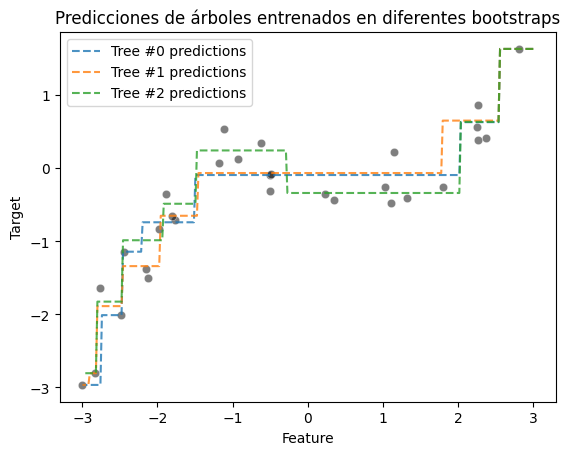

In [11]:
# Ahora que hemos creado una bolsa de diferentes árboles, podemos usar cada uno de los árboles para predecir las muestras dentro del rango de datos.
# Darán predicciones ligeramente diferentes.

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
for tree_idx, tree in enumerate(bag_of_trees):
    tree_predictions = tree.predict(data_test)
    plt.plot(data_test["Feature"], tree_predictions, linestyle="--", alpha=0.8,
             label=f"Tree #{tree_idx} predictions")

plt.legend()
_ = plt.title("Predicciones de árboles entrenados en diferentes bootstraps")

# Agregación

- Una vez que nuestros árboles están ajujstados, podemos obtener predicciones para cada uno de ellos.
- En la regresión, la forma más directa de combinar esas predicciones es solo promediarlas: 
    - para un punto de prueba dado, alimentamos los valores de la función de entrada a cada uno de los N modelos entrenados en el conjunto y, 
    - como resultado, calcula los valores predichos para la variable objetivo.
- La predicción final del conjunto para el punto de datos de la prueba es el promedio de esos valores de N.

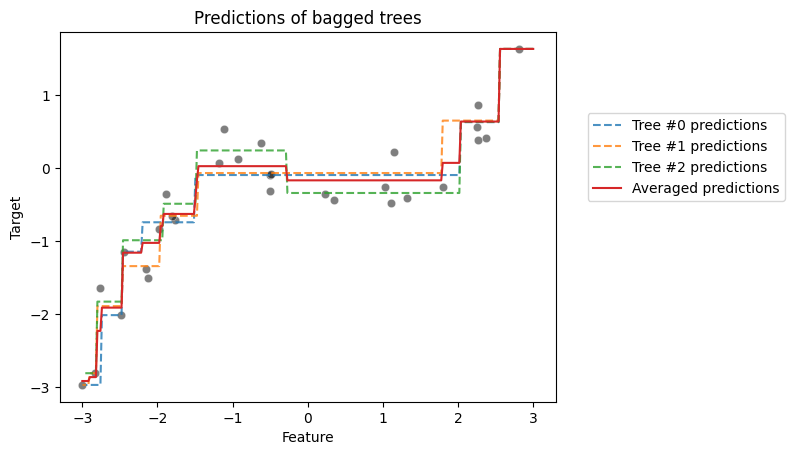

In [12]:
# graficamos las predicciones promedio del ejemplo anterior.

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)

bag_predictions = []
for tree_idx, tree in enumerate(bag_of_trees):
    tree_predictions = tree.predict(data_test)
    plt.plot(data_test["Feature"], tree_predictions, linestyle="--", alpha=0.8,
             label=f"Tree #{tree_idx} predictions")
    bag_predictions.append(tree_predictions)

bag_predictions = np.mean(bag_predictions, axis=0)
plt.plot(data_test["Feature"], bag_predictions, label="Averaged predictions",
         linestyle="-")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Predictions of bagged trees")

# Bagging en scikit-learn
Scikit-Learn implementa el procedimientocomo un **“meta-estimador”**, es decir, un estimador que envuelve otro estimador: 
- se necesita un modelo base que se clone varias veces y se entrene independientemente en cada muestra de arranque.

In [14]:
# Establecemo n_estimators = 100 para obtener un efecto de suavizado más fuerte.

from sklearn.ensemble import BaggingRegressor

bagged_trees = BaggingRegressor(
    estimator=DecisionTreeRegressor(max_depth=3),
    n_estimators=100,
)
_ = bagged_trees.fit(data_train, target_train)

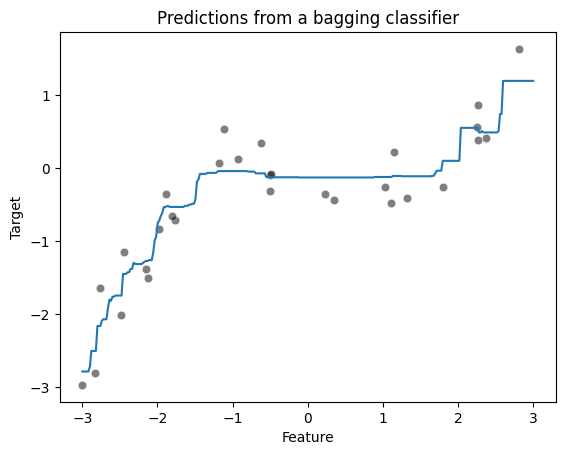

In [16]:
# Visualizamoz las predicciones del conjunto en el mismo intervalo de datos:

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)

bagged_trees_predictions = bagged_trees.predict(data_test)
plt.plot(data_test["Feature"], bagged_trees_predictions)

_ = plt.title("Predictions from a bagging classifier")

> Es posible acceder a los modelos internos del conjunto almacenado como una lista de Python en el atributo `bagged_trees.estimators_` después del ajuste.

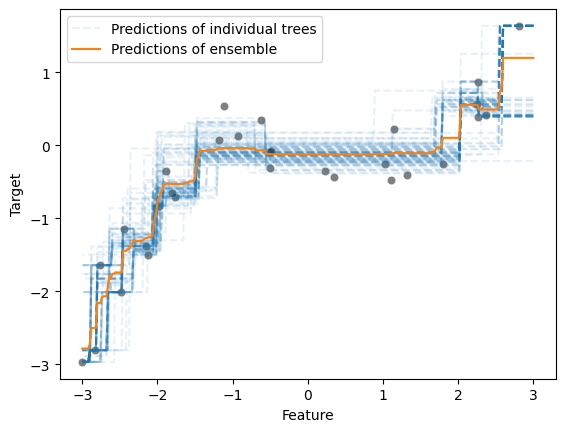

In [17]:
# Comparemos las predicciones basadas en el modelo con sus promedios:

for tree_idx, tree in enumerate(bagged_trees.estimators_):
    label = "Predictions of individual trees" if tree_idx == 0 else None
    # we convert `data_test` into a NumPy array to avoid a warning raised in scikit-learn
    tree_predictions = tree.predict(data_test.to_numpy())
    plt.plot(data_test["Feature"], tree_predictions, linestyle="--", alpha=0.1,
             color="tab:blue", label=label)

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)

bagged_trees_predictions = bagged_trees.predict(data_test)
plt.plot(data_test["Feature"], bagged_trees_predictions,
         color="tab:orange", label="Predictions of ensemble")
_ = plt.legend()

# Pipeline complejo
- Si bien utilizamos un árbol de decisión como modelo base, **nada nos impide usar otro tipo de modelo**.

- Como sabemos que la función de generación de datos original es una transformación polinómica ruidosa de la variable de entrada, intentemos ajustar un pipeline de regresión polinómica en este conjunto de datos:

In [18]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline


polynomial_regressor = make_pipeline(
    MinMaxScaler(),
    PolynomialFeatures(degree=4),
    Ridge(alpha=1e-10),
)

In [20]:
# El conjunto en sí se construye simplemente pasando el pipeline como parámetro `estimator` de la clase BaggingRegresor:

bagging = BaggingRegressor(
    estimator=polynomial_regressor,
    n_estimators=100,
    random_state=0,
)
_ = bagging.fit(data_train, target_train)

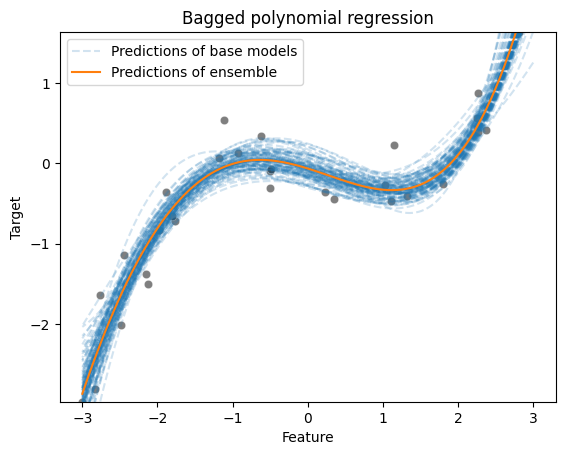

In [21]:
for i, regressor in enumerate(bagging.estimators_):
    # Convertimos `data_test` en una matriz numpy para evitar una advertencia planteada en Scikit-Learn
    regressor_predictions = regressor.predict(data_test.to_numpy())
    base_model_line = plt.plot(
        data_test["Feature"], regressor_predictions, linestyle="--", alpha=0.2,
        label="Predictions of base models" if i == 0 else None,
        color="tab:blue"
    )

sns.scatterplot(x=data_train["Feature"], y=target_train, color="black",
                alpha=0.5)
bagging_predictions = bagging.predict(data_test)
plt.plot(data_test["Feature"], bagging_predictions,
         color="tab:orange", label="Predictions of ensemble")
plt.ylim(target_train.min(), target_train.max())
plt.legend()
_ = plt.title("Bagged polynomial regression")